# Problem
Recurrent neural networks can also be used as **generative models**.

This means that in addition to being used for predictive models (making predictions) 
they can learn the sequences of a problem and 
then generate entirely new plausible sequences for the problem domain.

In this lesson we are going to use the dataset: ``Alice’s Adventures in Wonderland``.

We are going to learn the dependencies between characters and 
the conditional probabilities of characters in sequences 
so that we can in turn generate wholly new and original sequences of characters.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.saving import load_model
import sys
import os


2025-05-28 23:41:26.823081: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-28 23:41:26.834769: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748475686.846288 1118984 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748475686.849781 1118984 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748475686.860146 1118984 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Data preprocessing

In [2]:
# load dataset from file
dataset_path = "wonderland.txt"

# read file
with open(dataset_path, "r") as f:
    raw_text = f.read()
    raw_text = raw_text.lower()

print(raw_text)

chapter i. down the rabbit-hole

alice was beginning to get very tired of sitting by her sister on the
bank, and of having nothing to do: once or twice she had peeped into the
book her sister was reading, but it had no pictures or conversations in
it, ‘and what is the use of a book,’ thought alice ‘without pictures or
conversations?’

so she was considering in her own mind (as well as she could, for the
hot day made her feel very sleepy and stupid), whether the pleasure
of making a daisy-chain would be worth the trouble of getting up and
picking the daisies, when suddenly a white rabbit with pink eyes ran
close by her.

there was nothing so very remarkable in that; nor did alice think it so
very much out of the way to hear the rabbit say to itself, ‘oh dear!
oh dear! i shall be late!’ (when she thought it over afterwards, it
occurred to her that she ought to have wondered at this, but at the time
it all seemed quite natural); but when the rabbit actually took a watch
out of its waistco

In [3]:
# replacing "\n", "\t", "\r" with " " (space)
# in this way we can easily split dataset just using spaces 
raw_text = raw_text.replace("\n", " ").replace("\t", " ").replace("\r", " ")

In [ ]:
# let's count how many word our dataset is made up of
words = raw_text.split(" ") # all words
unique_words = set(words) # unique words

print(words)
print(unique_words)
print(len(unique_words))

['chapter', 'i.', 'down', 'the', 'rabbit-hole', '', 'alice', 'was', 'beginning', 'to', 'get', 'very', 'tired', 'of', 'sitting', 'by', 'her', 'sister', 'on', 'the', 'bank,', 'and', 'of', 'having', 'nothing', 'to', 'do:', 'once', 'or', 'twice', 'she', 'had', 'peeped', 'into', 'the', 'book', 'her', 'sister', 'was', 'reading,', 'but', 'it', 'had', 'no', 'pictures', 'or', 'conversations', 'in', 'it,', '‘and', 'what', 'is', 'the', 'use', 'of', 'a', 'book,’', 'thought', 'alice', '‘without', 'pictures', 'or', 'conversations?’', '', 'so', 'she', 'was', 'considering', 'in', 'her', 'own', 'mind', '(as', 'well', 'as', 'she', 'could,', 'for', 'the', 'hot', 'day', 'made', 'her', 'feel', 'very', 'sleepy', 'and', 'stupid),', 'whether', 'the', 'pleasure', 'of', 'making', 'a', 'daisy-chain', 'would', 'be', 'worth', 'the', 'trouble', 'of', 'getting', 'up', 'and', 'picking', 'the', 'daisies,', 'when', 'suddenly', 'a', 'white', 'rabbit', 'with', 'pink', 'eyes', 'ran', 'close', 'by', 'her.', '', 'there', 'w

In [5]:
# initialize our Encoder (words to int)
encoder = tf.keras.layers.TextVectorization(
    max_tokens=5000,
    # if needed we could work with ngrams too. Must specify number of ngrams
    ngrams=None, # 3
)
encoder.adapt(raw_text)

I0000 00:00:1748475691.517924 1118984 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1039 MB memory:  -> device: 0, name: NVIDIA A30 MIG 4g.24gb, pci bus id: 0000:81:00.0, compute capability: 8.0


In [6]:
# get our vocabulary
vocab = np.array(encoder.get_vocabulary())

display(vocab[:100])
print(len(vocab))

array(['', '[UNK]', 'the', 'and', 'to', 'a', 'she', 'of', 'said', 'it',
       'alice', 'in', 'was', 'you', 'i', 'as', 'her', 'that', 'at', 'on',
       'had', 'with', 'all', 'for', 'very', 'be', 'so', 'this', 'little',
       '‘i', 'but', 'not', 'they', 'out', 'he', 'down', 'his', 'what',
       'about', 'up', 'one', 'is', 'were', 'went', 'herself', 'like',
       'would', 'have', 'could', 'when', 'thought', 'them', 'no', 'if',
       'again', 'or', 'there', 'then', 'into', 'queen', 'see', 'do',
       'off', 'your', 'time', 'know', 'king', 'began', '‘and', 'its',
       'my', 'mock', 'by', 'an', 'quite', 'gryphon', 'did', 'who',
       'turtle', 'me', 'hatter', 'don’t', 'their', 'way', 'some', 'just',
       'voice', 'it’', 'more', 'how', 'only', 'looked', 'got', 'go',
       'which', 'first', 'are', 'think', 'must', 'much'], dtype='<U42')

3433


In [8]:
# define our sequence length
sequence_len = 100

In [ ]:
# hacking with sequences
first_sequence = words[0:sequence_len] # take the first sequence

display(first_sequence)

# get a string form a word sequence
display(" ".join(first_sequence))

# get the encoding of that sequence
display(encoder(" ".join(first_sequence)))

['chapter',
 'i.',
 'down',
 'the',
 'rabbit-hole',
 '',
 'alice',
 'was',
 'beginning',
 'to',
 'get',
 'very',
 'tired',
 'of',
 'sitting',
 'by',
 'her',
 'sister',
 'on',
 'the',
 'bank,',
 'and',
 'of',
 'having',
 'nothing',
 'to',
 'do:',
 'once',
 'or',
 'twice',
 'she',
 'had',
 'peeped',
 'into',
 'the',
 'book',
 'her',
 'sister',
 'was',
 'reading,',
 'but',
 'it',
 'had',
 'no',
 'pictures',
 'or',
 'conversations',
 'in',
 'it,',
 '‘and',
 'what',
 'is',
 'the',
 'use',
 'of',
 'a',
 'book,’',
 'thought',
 'alice',
 '‘without',
 'pictures',
 'or',
 'conversations?’',
 '',
 'so',
 'she',
 'was',
 'considering',
 'in',
 'her',
 'own',
 'mind',
 '(as',
 'well',
 'as',
 'she',
 'could,',
 'for',
 'the',
 'hot',
 'day',
 'made',
 'her',
 'feel',
 'very',
 'sleepy',
 'and',
 'stupid),',
 'whether',
 'the',
 'pleasure',
 'of',
 'making',
 'a',
 'daisy-chain',
 'would',
 'be',
 'worth',
 'the',
 'trouble']

'chapter i. down the rabbit-hole  alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, ‘and what is the use of a book,’ thought alice ‘without pictures or conversations?’  so she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the trouble'

<tf.Tensor: shape=(98,), dtype=int64, numpy=
array([ 314,   14,   35,    2,  963,   10,   12,  346,    4,  100,   24,
        492,    7,  360,   72,   16,  442,   19,    2, 1652,    3,    7,
        377,  147,    4,   61,  152,   55,  742,    6,   20,  978,   58,
          2,  701,   16,  442,   12,  961,   30,    9,   20,   52,  790,
         55, 3157,   11,    9,   68,   37,   41,    2,  213,    7,    5,
       1635,   50,   10, 1711,  790,   55, 3156,   26,    6,   12, 1121,
         11,   16,  369,  506,   15,  136,   15,    6,   48,   23,    2,
        678,  196,  143,   16,  471,   24,  640,    3, 1299,  329,    2,
       1390,    7,  459,    5, 3111,   46,   25,  727,    2,  625])>

In [ ]:
# generate our supervised dataset
# we need an input text and a label
# our input text will be a sentence (of length: sequence_len)
# our label (or ground truth) will be next word
# Eg: 
#    input text: Alice is taking a
#    label:     nap
dataset_x = []  # text input
dataset_y = []  # labels

for i in range(len(words)-sequence_len):
    seq_input = " ".join(words[i:i+sequence_len])
    seq_output = words[i+sequence_len]

    dataset_x.append(seq_input)
    dataset_y.append(seq_output)
    
# numpy conversion
dataset_x = np.array(dataset_x)
dataset_y = np.array(dataset_y)

In [11]:
print(dataset_x.shape)
print(dataset_y.shape)

(28276,)
(28276,)


In [12]:
x = dataset_x.reshape(-1, 1) # reshape to right shape

# labels are one-hot encoded
y = encoder(dataset_y)
y = to_categorical(y, num_classes=len(vocab))

In [13]:
print(x.shape)
print(y.shape)
print()
print(x)
print(y)

(28276, 1)
(28276, 3433)

[['chapter i. down the rabbit-hole  alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, ‘and what is the use of a book,’ thought alice ‘without pictures or conversations?’  so she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the trouble']
 ['i. down the rabbit-hole  alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, ‘and what is the use of a book,’ thought alice ‘without pictures or conversations?’  so she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stu

tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(28276, 3433), dtype=float32)


In [14]:
# creating a Tensorflow Dataset
dataset = tf.data.Dataset.from_tensor_slices((x, y))

display(dataset)
print(len(dataset))

<_TensorSliceDataset element_spec=(TensorSpec(shape=(1,), dtype=tf.string, name=None), TensorSpec(shape=(3433,), dtype=tf.float32, name=None))>

28276


In [15]:
# take and print first element of our dataset
for text, label in dataset.take(1):
    # text is an array made by one elem. It must be decoded to utf-8 to be 
    # displayed properly
    print("IN:", text[0].numpy().decode('utf-8'))
    print("LABEL:", label, f"({np.argmax(label)} --> {vocab[np.argmax(label)]})")

IN: chapter i. down the rabbit-hole  alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, ‘and what is the use of a book,’ thought alice ‘without pictures or conversations?’  so she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the trouble
LABEL: tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(3433,), dtype=float32) (7 --> of)


2025-05-28 23:41:33.041086: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [16]:
# train/test split
# using 5% of data as testing set
testing_len = int(len(dataset)*0.05)
training_len = len(dataset) - testing_len

print(training_len)
print(testing_len)

26863
1413


In [17]:
# generate train/test Tensorflow Datasets
# dividing in batch, prefetching elements and shuffling training set
train_dataset = dataset.take(training_len).shuffle(len(dataset)).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = dataset.skip(training_len).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
# take and print first training batch
for text, label in train_dataset.take(1):
    print(text.shape)
    print(label.shape)

(32, 1)
(32, 3433)


2025-05-28 23:41:33.501040: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## LSTM Model

In [19]:
# defining our Keras model using LSTM layer
model = tf.keras.Sequential([
    # Encoder layer
    encoder,
    # Trainable Embedding layer
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=256,
        mask_zero=True,  # remember padding and masking
    ),
    # LSTM layer with 256 units
    tf.keras.layers.LSTM(256),   
    # Dropout layer
    tf.keras.layers.Dropout(0.2),
    # Output layer
    tf.keras.layers.Dense(len(vocab), activation='softmax'),
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# callbacks
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=5,
    verbose=1,
    mode="min",
)

model_filepath="lstm_alice-mytraining.keras"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    model_filepath,
    monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    )

In [ ]:
history = model.fit(
    train_dataset,
    epochs=5, # Try with few epochs. We have a pre-trained model with 100 epochs
    callbacks=[es_callback, checkpoint_callback],
    )

Epoch 1/50


I0000 00:00:1748475695.679997 1119654 cuda_dnn.cc:529] Loaded cuDNN version 90300


840/840 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0694 - loss: 6.4661
Epoch 1: loss improved from inf to 6.16676, saving model to lstm_alice-pretrained-100e.keras
840/840 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.0695 - loss: 6.4658
Epoch 2/50
839/840 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1286 - loss: 5.5534
Epoch 2: loss improved from 6.16676 to 5.48974, saving model to lstm_alice-pretrained-100e.keras
840/840 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.1286 - loss: 5.5533
Epoch 3/50
839/840 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1720 - loss: 4.9654
Epoch 3: loss improved from 5.48974 to 4.95586, saving model to lstm_alice-pretrained-100e.keras
840/840 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.1720 - loss: 4.9654
Epoch 4/50
839/840 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2103 - loss: 4.4529
Epoch 4: loss improved from 4.95586 to 4.48602, saving model to lstm_alice-pretrained-100e.keras
840/840 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - acc

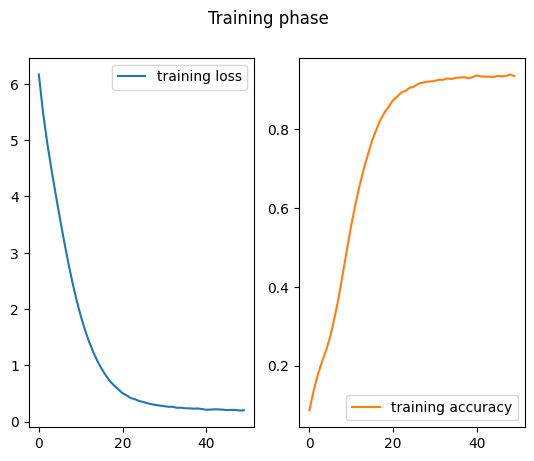

In [22]:
# Plot loss during training phase
fig, axis = plt.subplots(1, 2)
axis[0].plot(history.history['loss'])
axis[0].legend(["training loss"])
axis[1].plot(history.history['accuracy'], color="tab:orange")
axis[1].legend(["training accuracy"])
fig.suptitle("Training phase")
plt.show()

In [23]:
def test_model_output(model, train_dataset):
    for text, label in train_dataset.take(1):
        res = model.predict(text)
        pred_tokens = np.argmax(res, axis=1)
        
        print("Input Text:", text.shape)
        print("Model Preds:", res.shape)
        print("Pred Tokens:", pred_tokens.shape)
        print()
        
        for i, t in enumerate(text):
            print(t[0].numpy().decode('utf-8'))
            print("PRED:", vocab[pred_tokens[i]])
            print("TRUE:", vocab[np.argmax(label[i])])
            print()

In [24]:
# get some model preds
test_model_output(model, train_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Input Text: (32, 1)
Model Preds: (32, 3433)
Pred Tokens: (32,)

will you join the dance?  will you, won’t you, will you, won’t you, won’t you join the dance?”’  ‘thank you, it’s a very interesting dance to watch,’ said alice, feeling very glad that it was over at last: ‘and i do so like that curious song about the whiting!’  ‘oh, as to the whiting,’ said the mock turtle, ‘they--you’ve seen them, of course?’  ‘yes,’ said alice, ‘i’ve often seen them at dinn--’ she checked herself hastily.  ‘i don’t know where dinn may be,’ said the mock turtle, ‘but if you’ve seen them so often, of
PRED: course
TRUE: course

you hold it too long; and that if you cut your finger very deeply with a knife, it usually bleeds; and she had never forgotten that, if you drink much from a bottle marked ‘poison,’ it is almost certain to disagree with you, sooner or later.  however, this bottle was not marked ‘poison,’ so alice ventured to taste it, and finding it very nice, 

In [25]:
# load pre-trained model
model_filepath="lstm_alice-pretrained-100e.keras"
model_pretrained = load_model(model_filepath)
display(model_pretrained.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 256)      │       878,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3433)           │       882,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,859,325 (26.17 MB)

 Trainable params: 2,286,441 (8.72 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,572,884 (17.44 MB)

None

In [26]:
# get some model preds using pre-trained model
test_model_output(model_pretrained, train_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
Input Text: (32, 1)
Model Preds: (32, 3433)
Pred Tokens: (32,)

and out of breath, and till the puppy’s bark sounded quite faint in the distance.  ‘and yet what a dear little puppy it was!’ said alice, as she leant against a buttercup to rest herself, and fanned herself with one of the leaves: ‘i should have liked teaching it tricks very much, if--if i’d only been the right size to do it! oh dear! i’d nearly forgotten that i’ve got to grow up again! let me see--how is it to be managed? i suppose i ought to eat or drink something or other; but the great question is, what?’
PRED: 
TRUE: 

the first thing she heard was a general chorus of ‘there goes bill!’ then the rabbit’s voice along--‘catch him, you by the hedge!’ then silence, and then another confusion of voices--‘hold up his head--brandy now--don’t choke him--how was it, old fellow? what happened to you? tell us all about it!’  last came a little feeble, squeaking voice, [‘that’s bill,’ though

2025-05-28 23:50:02.621581: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [27]:
def test_model_random_texts(model):
    in_text = [
        ["The unicorn is flying into the"],
        ["Monkey are very"],
        ["Alice is taking a"],
        ]
    res = model.predict(tf.convert_to_tensor(in_text))

    for i, t in enumerate(in_text):
        print(t[0], end=" ")
        print(vocab[np.argmax(res[i])])

In [28]:
test_model_random_texts(model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
The unicorn is flying into the air
Monkey are very likely
Alice is taking a little


In [29]:
test_model_random_texts(model_pretrained)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
The unicorn is flying into the air
Monkey are very tired
Alice is taking a very


In [30]:
def autoregressive(model, tokens=20, sentence=2):
    sentences = [
        "Alice is taking a",
        "Monkey are very",
        "The unicorn is flying into the",
    ]
    in_text = sentences[sentence]

    for i in range(tokens):
        res = model.predict(tf.convert_to_tensor([[in_text]]))
        next_word = vocab[np.argmax(res)]
        in_text += f" {next_word}"
        
    print(in_text)

In [31]:
# testing model in an autoregressive mode
for i in range(3):
    autoregressive(model, sentence=i)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Alice is taking a little larger about it you know’              
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

In [32]:
# testing pre-trained model in an autoregressive mode
for i in range(3):
    autoregressive(model_pretrained, sentence=i)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Alice is taking a very curious thing i know it was like a little but i must go back by railway’   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

## Transformers

In [33]:
from keras_hub.layers import TokenAndPositionEmbedding, TransformerEncoder

/home/jovyan/Desktop/lezioni/11_Transformers/Transformers_for_next_char_prediction/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
# define our model using Transformer layer
model_transformer = Sequential([
    # Encoder layer
    encoder,
    # Embedding with PositionEncoding layer
    # This layer creates a keras.layers.Embedding token embedding and a
    # keras_hub.layers.PositionEmbedding position embedding and sums their output when called
    TokenAndPositionEmbedding(
        vocabulary_size=len(encoder.get_vocabulary()),
        sequence_length=sequence_len,
        embedding_dim=256, # model dim (d)
        mask_zero=True,
    ),
    # TransformerEncoder layer
    TransformerEncoder(
        # the hidden size of feedforward network.
        intermediate_dim=64,
        # the number of heads in the keras.layers.MultiHeadAttention layer
        num_heads=8,
    ),
    # Reduce tensor dimension by computing the mean over the temporal dimension (sequence length)
    # Our TransformerEncoder layers give us a tensor of shape (batch_size, sequence_length, embedding_dim)
    # That have an extra dimension: our final output shape must be (batch_size, vocab_length).
    # vocab_length --> our label is one-hot encoded !!
    # The final result will be (batch_size, embedding_dim)
    tf.keras.layers.GlobalAveragePooling1D(),
    # Dropout layer
    tf.keras.layers.Dropout(0.2),
    # Output layer
    tf.keras.layers.Dense(len(vocab), activation='softmax'),
])

model_transformer.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# want to check by yourself tensor shapes ?
# uncomment the following code and try to comment some model's layers
# model_transformer.predict(tf.convert_to_tensor([["im a test"]])).shape

In [ ]:
# SaveBest callback
model_filepath = "transformers_alice-mytraining.keras"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    model_filepath,
    monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    )

In [ ]:
history = model_transformer.fit(
    train_dataset,
    epochs=5,  # try using few epochs. We have a pre-trained version (100 epochs)
    callbacks=[checkpoint_callback]
    )

Epoch 1/50


/home/jovyan/Desktop/lezioni/11_Transformers/Transformers_for_next_char_prediction/env/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'position_embedding' (of type PositionEmbedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


838/840 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0752 - loss: 6.4743
Epoch 1: loss improved from inf to 6.28156, saving model to transformers_alice-pretrained-100e.keras
840/840 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.0752 - loss: 6.4736
Epoch 2/50
839/840 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0918 - loss: 5.9061
Epoch 2: loss improved from 6.28156 to 5.92023, saving model to transformers_alice-pretrained-100e.keras
840/840 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.0918 - loss: 5.9061
Epoch 3/50
839/840 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0911 - loss: 5.6493
Epoch 3: loss improved from 5.92023 to 5.66852, saving model to transformers_alice-pretrained-100e.keras
840/840 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.0911 - loss: 5.6493
Epoch 4/50
840/840 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1215 - loss: 5.1189
Epoch 4: loss improved from 5.66852 to 5.09157, saving model to transformers_alice-pretrained-100e.keras
840/840 ━━━━━━━━━━━━━━━━━

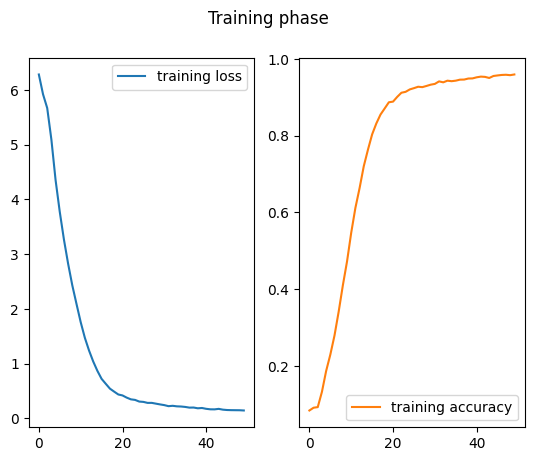

In [37]:
# Plot loss during training phase
fig, axis = plt.subplots(1, 2)
axis[0].plot(history.history['loss'])
axis[0].legend(["training loss"])
axis[1].plot(history.history['accuracy'], color="tab:orange")
axis[1].legend(["training accuracy"])
fig.suptitle("Training phase")
plt.show()

In [38]:
# load pre-trained model
model_filepath="transformers_alice-pretrained-100e.keras"
model_transformer_pretrained = load_model(model_filepath)
display(model_transformer_pretrained.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, None, 256)      │       904,448 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ (None, None, 256)      │       297,280 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3433)           │       882,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,252,029 (23.85 MB)

 Trainable params: 2,084,009 (7.95 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,168,020 (15.90 MB)

None

In [39]:
# get some model preds
test_model_output(model_transformer, train_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Input Text: (32, 1)
Model Preds: (32, 3433)
Pred Tokens: (32,)

crawling away: besides all this, there was generally a ridge or furrow in the way wherever she wanted to send the hedgehog to, and, as the doubled-up soldiers were always getting up and walking off to other parts of the ground, alice soon came to the conclusion that it was a very difficult game indeed.  the players all played at once without waiting for turns, quarrelling all the while, and fighting for the hedgehogs; and in a very short time the queen was in a furious passion, and went stamping about, and shouting ‘off with his head!’ or ‘off
PRED: with
TRUE: with

quite follow it as you say it.’  ‘that’s nothing to what i could say if i chose,’ the duchess replied, in a pleased tone.  ‘pray don’t trouble yourself to say it any longer than that,’ said alice.  ‘oh, don’t talk about trouble!’ said the duchess. ‘i make you a present of everything i’ve said as yet.’  ‘a cheap sort of pre

In [40]:
# get some model preds using pre-trained model
test_model_output(model_transformer_pretrained, train_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Input Text: (32, 1)
Model Preds: (32, 3433)
Pred Tokens: (32,)

the same year for such a long time together.’  ‘which is just the case with mine,’ said the hatter.  alice felt dreadfully puzzled. the hatter’s remark seemed to have no sort of meaning in it, and yet it was certainly english. ‘i don’t quite understand you,’ she said, as politely as she could.  ‘the dormouse is asleep again,’ said the hatter, and he poured a little hot tea upon its nose.  the dormouse shook its head impatiently, and said, without opening its eyes, ‘of course, of course; just what i was going to remark myself.’ 
PRED: ‘have
TRUE: ‘have

was addressed to the baby, and not to her, so she took courage, and went on again:--  ‘i didn’t know that cheshire cats always grinned; in fact, i didn’t know that cats could grin.’  ‘they all can,’ said the duchess; ‘and most of ‘em do.’  ‘i don’t know of any that do,’ alice said very politely, feeling quite pleased to have got into a 

In [41]:
test_model_random_texts(model_transformer)
test_model_random_texts(model_transformer_pretrained)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
The unicorn is flying into the next
Monkey are very back
Alice is taking a it
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
The unicorn is flying into the next
Monkey are very back
Alice is taking a it


In [42]:
# testing model in an autoregressive mode
for i in range(3):
    autoregressive(model_transformer, sentence=i)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Alice is taking a it in it little little little little little little little and little little little little little hot come back quickly
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

In [43]:
# testing pre-trained model in an autoregressive mode
for i in range(3):
    autoregressive(model_transformer_pretrained, sentence=i)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Alice is taking a it in it little little little little little little little and little little little little little hot come back quickly
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

## LSTM vs Transformers

In [44]:
eval_lstm = model.evaluate(test_dataset)
eval_lstm_pretrained = model_pretrained.evaluate(test_dataset)
eval_transformers = model_transformer.evaluate(test_dataset)
eval_transformers_pretrained = model_transformer_pretrained.evaluate(test_dataset)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1034 - loss: 9.8148
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0984 - loss: 9.7063
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0776 - loss: 13.5659
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0776 - loss: 13.5659


In [45]:
print("LSTM (mytrain):", eval_lstm)
print("LSTM (pre-trained):", eval_lstm_pretrained)
print("Transformers (mytrain):", eval_transformers)
print("Transformers (pre-trained):", eval_transformers_pretrained)

LSTM (mytrain): [10.67935562133789, 0.09412597119808197]
LSTM (pre-trained): [10.570151329040527, 0.09766454249620438]
Transformers (mytrain): [14.421265602111816, 0.07784854620695114]
Transformers (pre-trained): [14.421265602111816, 0.07784854620695114]
